In [304]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
train_df = pd.read_parquet("../Data/train_final_v3.parquet")
val_df = pd.read_parquet("../Data/validationA_v3.parquet")

In [5]:
print(train_df.shape)
print(val_df.shape)

(112768, 791)
(24164, 791)


In [12]:
train_df.iloc[:,:25].dtypes

category                            object
missing_price                         bool
item_rank                          float64
match                                int64
avg_rating                         float64
min_rating                           int64
percent_positive                   float64
percent_negative                   float64
avg_verified_reviewers             float64
min_date                    datetime64[ns]
max_date                    datetime64[ns]
product_lifespan           timedelta64[ns]
num_bots_per_asin                    int64
unique_reviewer_count                int64
avg_reviews_per_day                float64
reviews_per_product                  int64
avg_review_length_words            float64
embed_0                            float64
embed_1                            float64
embed_2                            float64
embed_3                            float64
embed_4                            float64
embed_5                            float64
embed_6    

In [7]:
X_train = train_df.drop(columns=['match'], axis=1)
X_val = val_df.drop(columns=['match'], axis=1)
y_train = train_df['match']
y_val = val_df['match']

In [9]:
X_train_raw = X_train
X_val_raw = X_val

## Columns Type Updated

In [11]:
for df in (X_train, X_val):
    df['review_span'] = (df['max_date'] - df['min_date']).dt.days
    df.drop(['min_date', 'max_date'], axis=1, inplace=True)

for df in (X_train, X_val):
    df['missing_price'] = df['missing_price'].astype(int)

for df in (X_train, X_val):
    df['product_lifespan_days'] = df['product_lifespan'].dt.days
    df.drop('product_lifespan', axis=1, inplace=True)

print(f"The shape of X_train: {X_train.shape}, X_val: {X_val.shape}")

The shape of X_train: (112768, 789), X_val: (24164, 789)


## Correlation Analysis

                     Feature1               Feature2  correlation
1574               avg_rating       percent_positive     0.928199
1575               avg_rating       percent_negative    -0.902056
6269    unique_reviewer_count    reviews_per_product     0.987056
310077            review_span  product_lifespan_days     1.000000


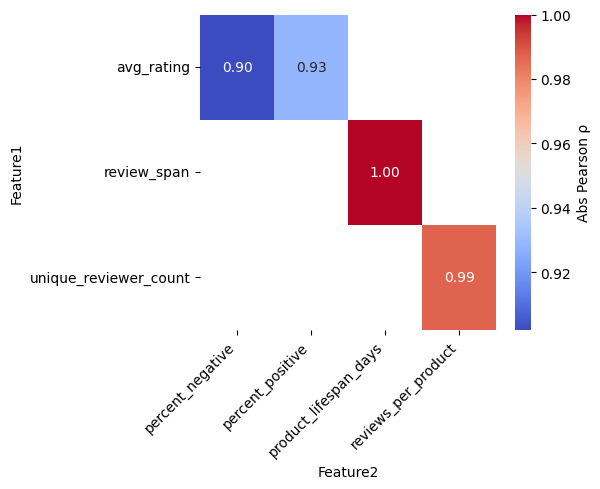

In [19]:
import numpy as np, seaborn as sns, matplotlib.pyplot as plt
corr = X_train.drop(columns=['category']).corr()
mask = np.triu(np.ones(corr.shape, dtype=bool), k=1)
high_corr_pairs = (corr.where(mask).stack().reset_index(name='correlation')
                   .query('abs(correlation) > 0.9')
                   .rename(columns={'level_0':'Feature1','level_1':'Feature2'}))
print(high_corr_pairs)
top = (high_corr_pairs.assign(AbsCorr=lambda df: df['correlation'].abs())
       .nlargest(50,'AbsCorr')
       .pivot(index='Feature1', columns='Feature2', values='AbsCorr'))
plt.figure(figsize=(6,5))
ax = sns.heatmap(top, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label':'Abs Pearson ρ'})
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center')
plt.tight_layout(); plt.show()

We will drop the columns `percent_positive`, `percent_negative`,  `review_span ` and `unique_reviewer_count` as they exhibit high correlation with other features, which may introduce multicollinearity into the model.

In [13]:
for df in (X_train, X_val):
    df.drop(['percent_positive', 'percent_negative', 'unique_reviewer_count', 'review_span'], axis=1, inplace=True)

## Preprocessing, PCA

In [15]:
from typing import List, Tuple
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


def make_transformer(df,r, s, drop_first=True):
    rev_cols  = [c for c in df if c.startswith("embedding_")]
    summ_cols = [c for c in df if c.startswith("embed_")]
    numeric_cols  = [c for c in df if c not in rev_cols+summ_cols+["category"]]

    rev_pipe  = ("drop" if r == 0 else Pipeline([("scale",StandardScaler()), ("pca",PCA(n_components=r,random_state=42))]))
    sum_pipe  = ("drop" if s == 0 else Pipeline([("scale",StandardScaler()), ("pca",PCA(n_components=s,random_state=42))]))

    return ColumnTransformer(
        [('num', StandardScaler(), numeric_cols),
         ('cat', OneHotEncoder(handle_unknown="ignore", drop="first" if drop_first else None, sparse_output=False), ["category"]),
         ('rev', rev_pipe,  rev_cols),
         ('sum', sum_pipe,  summ_cols)
        ]).set_output(transform="pandas")

In [17]:
preprocessor = make_transformer(X_train, 0.95, 0.95)
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)

In [19]:
# Column Types
num_cols = [c for c in X_train_proc.columns if c.startswith("num__")]
cat_cols       = [c for c in X_train_proc.columns if c.startswith("cat__")]
rev_cols       = [c for c in X_train_proc.columns if c.startswith("rev__")]
sum_cols       = [c for c in X_train_proc.columns if c.startswith("sum__")]

## Multicollinearity: Variance Inflation Factor (VIF) On Non-Embedding Features:

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(X_train_proc, numeric_cols, categorical_cols, thresh=10):
    nonembed_cols = numeric_cols + categorical_cols
    X_vif = X_train_proc[nonembed_cols].copy()

    # drop constant / near-constant columns
    const_cols = X_vif.columns[X_vif.std() < 1e-12]
    if len(const_cols):
        X_vif.drop(columns=const_cols, inplace=True)

    # VIF calculation 
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    # Print features with VIF > 10
    high_vif = vif_data[vif_data["VIF"] > thresh].sort_values("VIF", ascending=False)
    if not high_vif.empty:
        print(f"Features with VIF > {thresh}:")
        print(high_vif.to_string(index=False))
    else:
        print(f"No features with VIF > {thresh}")

    return vif_data

In [51]:
vif_data = compute_vif(X_train_proc, num_cols, cat_cols, thresh=10)

No features with VIF > 10


## Logistic Regression

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score

log_reg = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear', class_weight="balanced", random_state=42)
log_reg.fit(X_train_proc, y_train)

y_pred = log_reg.predict(X_val_proc)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

recall_macro = recall_score(y_val, y_pred, average='macro')
print("Macro Recall:", recall_macro)

Accuracy: 0.8540390663797385
Confusion Matrix:
 [[20536  3464]
 [   63   101]]
Macro Recall: 0.735760162601626


In [21]:
import sys
from pathlib import Path

project_root = Path().resolve().parent   
sys.path.insert(0, str(project_root / "src"))

## Custom KFold

In [23]:
from get_cv_split import PredefinedKFold
split_data=pd.read_parquet("../Data/CV_val_split.parquet")
assert((split_data.index==X_train.index).all()) # Sanity check to verify indices of X_train match up with indices of split_data
kfold=PredefinedKFold(split_data)

In [94]:
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import cross_val_score

recall_macro_scorer = make_scorer(recall_score, average='macro')

scores = cross_val_score(log_reg, X_train_proc, y_train, cv=kfold, scoring=recall_macro_scorer)

print("Macro Recall (per fold):", scores)
print("Mean Macro Recall:", scores.mean())


Macro Recall (per fold): [0.66176221 0.61062747 0.5902162 ]
Mean Macro Recall: 0.6208686262926213


### GridSearchCV on r and s (The PCA dimension of Review and Summary Embeddings)

In [95]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, average_precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

pipe = Pipeline([
    ("fe", make_transformer(X_train, r=50, s=10)),  # Dummy values, will be overridden by grid search
    ("logreg", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])

grid_vals = [10, 20, 50, 100]
param_grid = {
    "fe__rev__pca__n_components": grid_vals,  # r
    "fe__sum__pca__n_components": grid_vals   # s
}

scorers = {
    "pr_auc": make_scorer(average_precision_score, needs_proba=True),
    "recall_macro": make_scorer(recall_score, average="macro"),
    "f1_macro": make_scorer(f1_score, average="macro"),
}

# Run GridSearchCV
gcv = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scorers,
    refit="recall_macro",  
    cv=kfold,              
    n_jobs=20,
    return_train_score=False,
    verbose=1
)

# Fit
gcv.fit(X_train, y_train)  

# Extract results
results = (
    pd.DataFrame(gcv.cv_results_)
    .loc[:, [
        "param_fe__rev__pca__n_components",
        "param_fe__sum__pca__n_components",
        "mean_test_pr_auc", "std_test_pr_auc",
        "mean_test_recall_macro", "std_test_recall_macro",
        "mean_test_f1_macro", "std_test_f1_macro"
    ]]
    .rename(columns={
        "param_fe__rev__pca__n_components": "r",
        "param_fe__sum__pca__n_components": "s",
        "mean_test_pr_auc": "pr_auc_mean",
        "std_test_pr_auc": "pr_auc_std",
        "mean_test_recall_macro": "recall_macro_mean",
        "std_test_recall_macro": "recall_macro_std",
        "mean_test_f1_macro": "f1_macro_mean",
        "std_test_f1_macro": "f1_macro_std"
    })
    .sort_values("recall_macro_mean", ascending=False)
    .reset_index(drop=True)
)

print(results.head())

# Best model ready to use
best_lr = gcv.best_estimator_


Fitting 3 folds for each of 16 candidates, totalling 48 fits


C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


     r    s  pr_auc_mean  pr_auc_std  recall_macro_mean  recall_macro_std  \
0   50   10     0.041231    0.011392           0.639404          0.047560   
1  100   50     0.034951    0.009601           0.636770          0.044809   
2   50   20     0.041029    0.011711           0.634945          0.046026   
3  100   10     0.037633    0.009054           0.634354          0.048340   
4  100  100     0.033521    0.009815           0.632194          0.037666   

   f1_macro_mean  f1_macro_std  
0       0.469341      0.004529  
1       0.476090      0.004948  
2       0.468916      0.004182  
3       0.474171      0.004917  
4       0.477608      0.004493  


From the results, we observe that there is not much difference between the different values of r and s. So, we will choose r = 50 and s = 10 since with these values model performs best.

## Feature Selection With Logistic Regression

#### Preprocessing with r=50, s=10

In [25]:
preprocessor = make_transformer(X_train, r=50, s=10)
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
# update columns names
num_cols = [c for c in X_train_proc.columns if c.startswith("num__")]
cat_cols       = [c for c in X_train_proc.columns if c.startswith("cat__")]
rev_cols       = [c for c in X_train_proc.columns if c.startswith("rev__")]
sum_cols       = [c for c in X_train_proc.columns if c.startswith("sum__")]

print(f"After preprocessing X_train_proc:", X_train_proc.shape)
print(f"After preprocessing X_val_proc:", X_val_proc.shape)

After preprocessing X_train_proc: (112768, 95)
After preprocessing X_val_proc: (24164, 95)


Selected 95 features out of 95


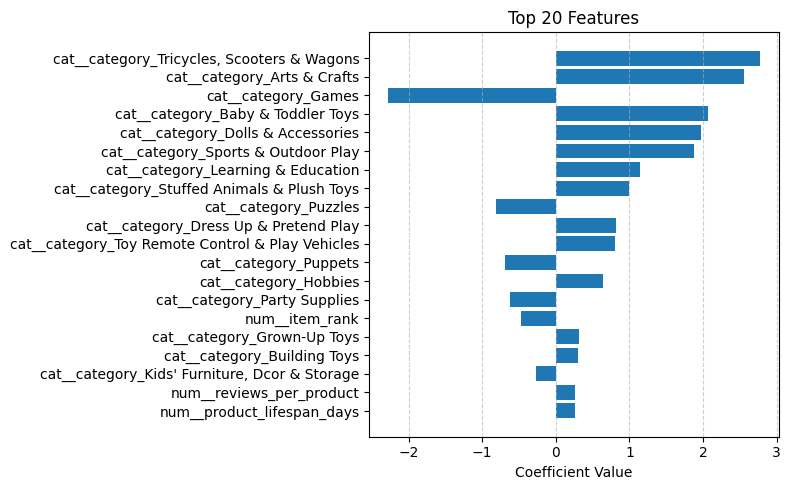

In [312]:
from feature_importance import plot_top_features
l1_model = LogisticRegression(penalty='l1', solver='saga', class_weight='balanced', C=0.1, random_state=42)
selected_feats_logreg = plot_top_features(l1_model, X_train_proc, y_train)

**Handling Categorical Features**

Our initial analysis indicated that categorical features are highly important. However, because we used a custom K-Fold splitting strategy where entire components were assigned to either the training or validation set, the distribution of categorical features varied significantly between the training and validation sets. This distribution shift raised concerns about model generalizability.

To address this, we evaluated models both with and without the categorical features. In the validation set, including them reduced false positives, whereas in cross-validation, excluding them resulted in better overall performance. We also tested including only high-importance or low-importance categorical features, but the results remained inconsistent between validation and cross-validation.

Due to these conflicting outcomes, we decided to build multiple model variants, some including categorical features and some excluding them. These models will be evaluated on the test set to determine which approach performs best.

In [31]:
# Drop category columns
X_train_proc_wo_cat = X_train_proc.drop(columns=cat_cols, axis=1)
X_val_proc_wo_cat = X_val_proc.drop(columns=cat_cols, axis=1)

print(f"After dropping categorical columns from train dataframe:", X_train_proc_wo_cat.shape)
print(f"After dropping categorical columns from val dataframe:", X_val_proc_wo_cat.shape)

After dropping categorical columns from train dataframe: (112768, 76)
After dropping categorical columns from val dataframe: (24164, 76)


Selected 76 features out of 76


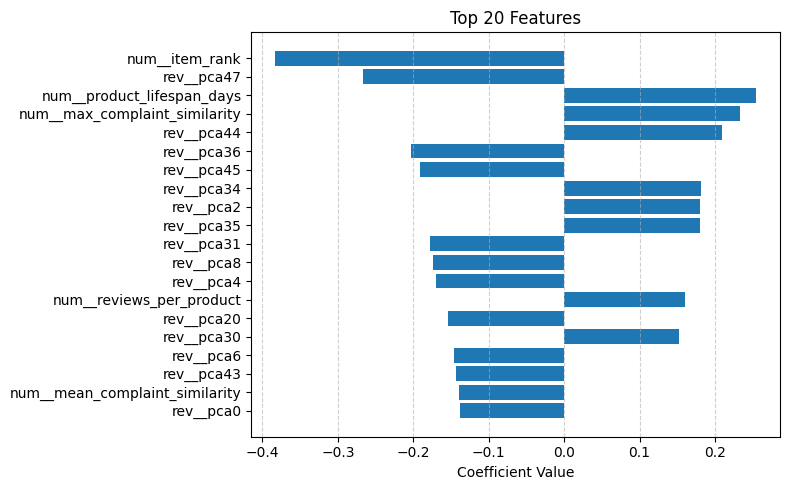

In [314]:
l1_model = LogisticRegression(penalty='l1', solver='saga', class_weight='balanced', C=0.1, random_state=42)
selected_feats_logreg = plot_top_features(l1_model, X_train_proc_wo_cat, y_train)

In [109]:
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import cross_val_score

recall_macro_scorer = make_scorer(recall_score, average='macro')

scores = cross_val_score(log_reg, X_train_proc_wo_cat, y_train, cv=kfold, scoring=recall_macro_scorer)

print("Macro Recall (per fold):", scores)
print("Mean Macro Recall:", scores.mean())

Macro Recall (per fold): [0.70969658 0.61741045 0.65258122]
Mean Macro Recall: 0.659896083803898


In [112]:
log_reg = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear', class_weight="balanced", random_state=42)
log_reg.fit(X_train_proc_wo_cat, y_train)

y_pred = log_reg.predict(X_val_proc_wo_cat)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

recall_macro = recall_score(y_val, y_pred, average='macro')
print("Macro Recall:", recall_macro)

Accuracy: 0.7825277271974839
Confusion Matrix:
 [[18788  5212]
 [   43   121]]
Macro Recall: 0.760319105691057


Dropping category features improves cross validation scores.

## Hyperparameter Tuning

### Logistic Regression Gridsearchcv

**Metric Selection**

`Macro recall` is the metric we are primarily interested in, as we aim to capture the positive class as much as possible.  

**Class Weight:**
We will run separate instances of `GridSearchCV` for each class weight configuration to observe how the macro recall score varies with each.

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score, average_precision_score
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

def run_logreg_gridsearch(X, y, cv, class_weight_options, verbose=2, n_jobs=20):
    
    base_model = LogisticRegression(max_iter=1000, random_state=42)

    param_grid = []

    # L1 penalty
    param_grid.append({
        'penalty': ['l1'],
        'solver': ['liblinear', 'saga'],
        'C': [0.01, 0.1, 1.0, 10.0],
        'class_weight': class_weight_options
    })

    # L2 penalty
    param_grid.append({
        'penalty': ['l2'],
        'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
        'C': [0.01, 0.1, 1.0, 10.0],
        'class_weight': class_weight_options
    })

    # No penalty (aka penalty=None)
    param_grid.append({
        'penalty': [None],
        'solver': ['lbfgs', 'saga', 'newton-cg'],
        'class_weight': class_weight_options
    })

    # Scorers
    scorers = {
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_macro': make_scorer(f1_score, average='macro'),
        'pr_auc': make_scorer(average_precision_score, needs_proba=True)
    }

    # GridSearchCV
    gcv = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring=scorers,
        refit='recall_macro',
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose,
        error_score='raise'
    )

    gcv.fit(X, y)

    results = pd.DataFrame(gcv.cv_results_).sort_values("mean_test_recall_macro", ascending=False)
    top_cols = [
        'param_penalty', 'param_solver', 'param_C', 'param_class_weight',
        'mean_test_recall_macro', 'mean_test_f1_macro', 'mean_test_pr_auc'
    ]
    print(results[top_cols].head(10))
    return gcv, results[top_cols]

#### Logistic Regression, Without Category Columns, With Different Class Weights:

In [66]:
# without category class weight balanced gridsearch_cv:
n_jobs=20
class_weight_options = ['balanced']
gcv_log_reg_wo_category_balanced, results_log_reg_wo_category_balanced = run_logreg_gridsearch(X_train_proc_wo_cat, y_train, cv=kfold, class_weight_options=class_weight_options, verbose=2, n_jobs=n_jobs)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
   param_penalty param_solver  param_C param_class_weight  \
5             l1         saga     1.00           balanced   
21            l2         saga    10.00           balanced   
20            l2    liblinear    10.00           balanced   
19            l2    newton-cg     1.00           balanced   
6             l1    liblinear    10.00           balanced   
16            l2    liblinear     1.00           balanced   
15            l2    newton-cg     0.10           balanced   
12            l2    liblinear     0.10           balanced   
8             l2    liblinear     0.01           balanced   
26          None    newton-cg      NaN           balanced   

    mean_test_recall_macro  mean_test_f1_macro  mean_test_pr_auc  
5                 0.672709            0.459832          0.043090  
21                0.663394            0.456234          0.028334  
20                0.660567            0.465140          0.036856  

In [74]:
# test gridsearch_cv results with validation set
import importlib              
import evaluator               
importlib.reload(evaluator)   
from evaluator import evaluate_param_list
val_results = evaluate_param_list(results_log_reg_wo_category_balanced, gcv_log_reg_wo_category_balanced.estimator, X_train_proc_wo_cat, y_train,
    X_val_proc_wo_cat, y_val, top_n=10, n_jobs=n_jobs)

display(val_results.head(10))

,penalty,solver,C,class_weight,recall_macro_val,f1_macro_val,pr_auc_val,confusion_matrix
0,l1,saga,1.00,balanced,0.770313,0.457281,0.027055,"[[18536, 5464], [38, 126]]"
1,l2,saga,10.00,balanced,0.767306,0.457135,0.026743,"[[18538, 5462], [39, 125]]"
2,l2,liblinear,10.00,balanced,0.760340,0.460683,0.023598,"[[18789, 5211], [43, 121]]"
3,l2,newton-cg,1.00,balanced,0.760340,0.460683,0.023595,"[[18789, 5211], [43, 121]]"
4,l1,liblinear,10.00,balanced,0.760340,0.460683,0.023598,"[[18789, 5211], [43, 121]]"
5,l2,liblinear,1.00,balanced,0.760340,0.460683,0.023598,"[[18789, 5211], [43, 121]]"
9,None,newton-cg,NaN,balanced,0.760340,0.460683,0.023595,"[[18789, 5211], [43, 121]]"
6,l2,newton-cg,0.10,balanced,0.760319,0.460666,0.023597,"[[18788, 5212], [43, 121]]"
7,l2,liblinear,0.10,balanced,0.760298,0.460649,0.023601,"[[18787, 5213], [43, 121]]"
8,l2,liblinear,0.01,balanced,0.759652,0.460119,0.023647,"[[18756, 5244], [43, 121]]"


In [76]:
# without category class weight 250 gridsearch_cv:
class_weight_options = [{0: 1, 1: 250}]
gcv_log_reg_wo_category_250, results_log_reg_wo_category_250 = run_logreg_gridsearch(X_train_proc_wo_cat, y_train, cv=kfold, class_weight_options=class_weight_options, verbose=2, n_jobs=n_jobs)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
   param_penalty param_solver  param_C param_class_weight  \
25          None         saga      NaN     {0: 1, 1: 250}   
22            l2        lbfgs    10.00     {0: 1, 1: 250}   
24          None        lbfgs      NaN     {0: 1, 1: 250}   
15            l2    newton-cg     0.10     {0: 1, 1: 250}   
18            l2        lbfgs     1.00     {0: 1, 1: 250}   
12            l2    liblinear     0.10     {0: 1, 1: 250}   
10            l2        lbfgs     0.01     {0: 1, 1: 250}   
14            l2        lbfgs     0.10     {0: 1, 1: 250}   
23            l2    newton-cg    10.00     {0: 1, 1: 250}   
26          None    newton-cg      NaN     {0: 1, 1: 250}   

    mean_test_recall_macro  mean_test_f1_macro  mean_test_pr_auc  
25                0.676320            0.417295          0.027960  
22                0.671754            0.430850          0.036944  
24                0.671736            0.430835          0.036926  

In [79]:
val_results = evaluate_param_list(results_log_reg_wo_category_250, gcv_log_reg_wo_category_250.estimator, X_train_proc_wo_cat, y_train,
    X_val_proc_wo_cat, y_val, top_n=10, n_jobs=n_jobs)

display(val_results.head(10))

,penalty,solver,C,class_weight,recall_macro_val,f1_macro_val,pr_auc_val,confusion_matrix
3,l2,newton-cg,0.10,"{0: 1, 1: 250}",0.769316,0.421731,0.022779,"[[16293, 7707], [23, 141]]"
8,l2,newton-cg,10.00,"{0: 1, 1: 250}",0.769316,0.421731,0.022778,"[[16293, 7707], [23, 141]]"
9,None,newton-cg,NaN,"{0: 1, 1: 250}",0.769316,0.421731,0.022778,"[[16293, 7707], [23, 141]]"
5,l2,liblinear,0.10,"{0: 1, 1: 250}",0.769295,0.421714,0.022780,"[[16292, 7708], [23, 141]]"
7,l2,lbfgs,0.10,"{0: 1, 1: 250}",0.769274,0.421697,0.022797,"[[16291, 7709], [23, 141]]"
1,l2,lbfgs,10.00,"{0: 1, 1: 250}",0.769211,0.421646,0.022802,"[[16288, 7712], [23, 141]]"
2,None,lbfgs,NaN,"{0: 1, 1: 250}",0.769191,0.421629,0.022799,"[[16287, 7713], [23, 141]]"
4,l2,lbfgs,1.00,"{0: 1, 1: 250}",0.769191,0.421629,0.022799,"[[16287, 7713], [23, 141]]"
6,l2,lbfgs,0.01,"{0: 1, 1: 250}",0.769170,0.421612,0.022803,"[[16286, 7714], [23, 141]]"
0,None,saga,NaN,"{0: 1, 1: 250}",0.641566,0.414106,0.010681,"[[16161, 7839], [64, 100]]"


In [80]:
# without category class weight 400 gridsearch_cv:
class_weight_options = [{0: 1, 1: 400}]
gcv_log_reg_wo_category_400, results_log_reg_wo_category_400 = run_logreg_gridsearch(X_train_proc_wo_cat, y_train, cv=kfold, class_weight_options=class_weight_options, verbose=2, n_jobs=n_jobs)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
   param_penalty param_solver  param_C param_class_weight  \
3             l1         saga      0.1     {0: 1, 1: 400}   
22            l2        lbfgs     10.0     {0: 1, 1: 400}   
6             l1    liblinear     10.0     {0: 1, 1: 400}   
20            l2    liblinear     10.0     {0: 1, 1: 400}   
24          None        lbfgs      NaN     {0: 1, 1: 400}   
18            l2        lbfgs      1.0     {0: 1, 1: 400}   
16            l2    liblinear      1.0     {0: 1, 1: 400}   
4             l1    liblinear      1.0     {0: 1, 1: 400}   
12            l2    liblinear      0.1     {0: 1, 1: 400}   
15            l2    newton-cg      0.1     {0: 1, 1: 400}   

    mean_test_recall_macro  mean_test_f1_macro  mean_test_pr_auc  
3                 0.695565            0.391066          0.019512  
22                0.683337            0.395570          0.036364  
6                 0.683330            0.395564          0.036411  

In [81]:
val_results = evaluate_param_list(results_log_reg_wo_category_400, gcv_log_reg_wo_category_400.estimator, X_train_proc_wo_cat, y_train,
    X_val_proc_wo_cat, y_val, top_n=10, n_jobs=n_jobs)

display(val_results.head(10))

,penalty,solver,C,class_weight,recall_macro_val,f1_macro_val,pr_auc_val,confusion_matrix
4,None,lbfgs,NaN,"{0: 1, 1: 400}",0.746734,0.380878,0.022075,"[[13892, 10108], [14, 150]]"
5,l2,lbfgs,1.0,"{0: 1, 1: 400}",0.746734,0.380878,0.022075,"[[13892, 10108], [14, 150]]"
1,l2,lbfgs,10.0,"{0: 1, 1: 400}",0.746713,0.380860,0.022077,"[[13891, 10109], [14, 150]]"
2,l1,liblinear,10.0,"{0: 1, 1: 400}",0.746713,0.380860,0.022060,"[[13891, 10109], [14, 150]]"
3,l2,liblinear,10.0,"{0: 1, 1: 400}",0.746713,0.380860,0.022060,"[[13891, 10109], [14, 150]]"
6,l2,liblinear,1.0,"{0: 1, 1: 400}",0.746713,0.380860,0.022060,"[[13891, 10109], [14, 150]]"
9,l2,newton-cg,0.1,"{0: 1, 1: 400}",0.746713,0.380860,0.022066,"[[13891, 10109], [14, 150]]"
7,l1,liblinear,1.0,"{0: 1, 1: 400}",0.746671,0.380824,0.022061,"[[13889, 10111], [14, 150]]"
8,l2,liblinear,0.1,"{0: 1, 1: 400}",0.746650,0.380806,0.022059,"[[13888, 10112], [14, 150]]"
0,l1,saga,0.1,"{0: 1, 1: 400}",0.674792,0.379425,0.014028,"[[13951, 10049], [38, 126]]"


#### Best Models When Categorical Columns Are Excluded

In [333]:
model_1 = LogisticRegression(penalty='l1', solver='saga', C=1.0, class_weight='balanced', max_iter=1000, random_state=42)
model_2 = LogisticRegression(penalty='l2', solver='newton-cg', C=0.1, class_weight={0: 1, 1: 250}, max_iter=1000, random_state=42) # best overall
model_3 = LogisticRegression(penalty=None, solver='lbfgs', class_weight={0: 1, 1: 400}, max_iter=1000, random_state=42)

# save models:
import os
import joblib 
model_2.fit(X_train_proc_wo_cat, y_train)
joblib.dump(model_2, "../Models/model_2.pkl")

['../Models/model_2.pkl']

 Validation Results:
Recall (macro):     0.7693
F1-score (macro):   0.4217
PR-AUC:             0.0228
              precision    recall  f1-score   support

           0       1.00      0.68      0.81     24000
           1       0.02      0.86      0.04       164

    accuracy                           0.68     24164
   macro avg       0.51      0.77      0.42     24164
weighted avg       0.99      0.68      0.80     24164



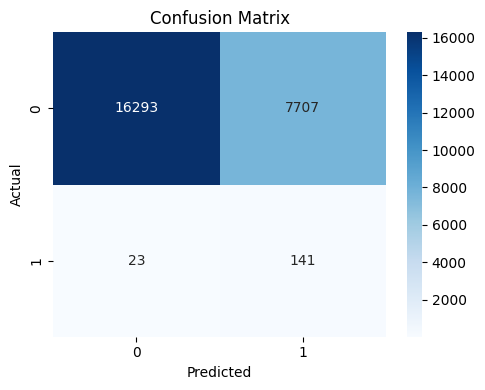

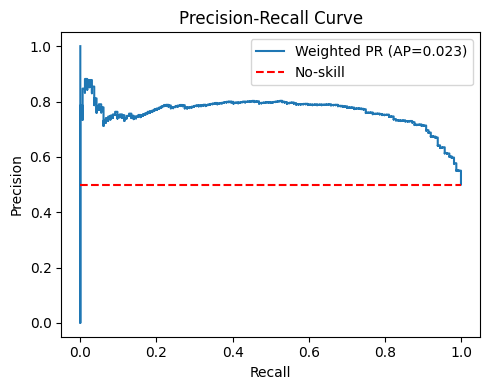

In [335]:
evaluate_model(model_2,X_val_proc_wo_cat, y_val)

#### Logistic Regression, With Category Columns, With Different Class Weights:

In [90]:
#class weight balanced
class_weight_options = ['balanced']
gcv_log_reg_balanced, results_log_reg_balanced = run_logreg_gridsearch(X_train_proc, y_train, cv=kfold, class_weight_options=class_weight_options, verbose=2, n_jobs=n_jobs)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
   param_penalty param_solver  param_C param_class_weight  \
11            l2    newton-cg     0.01           balanced   
10            l2        lbfgs     0.01           balanced   
8             l2    liblinear     0.01           balanced   
15            l2    newton-cg     0.10           balanced   
12            l2    liblinear     0.10           balanced   
0             l1    liblinear     0.01           balanced   
14            l2        lbfgs     0.10           balanced   
2             l1    liblinear     0.10           balanced   
18            l2        lbfgs     1.00           balanced   
19            l2    newton-cg     1.00           balanced   

    mean_test_recall_macro  mean_test_f1_macro  mean_test_pr_auc  
11                0.642686            0.470241          0.039159  
10                0.642675            0.470233          0.039152  
8                 0.642023            0.469240          0.039360  

In [91]:
val_results = evaluate_param_list(results_log_reg_balanced, gcv_log_reg_balanced.estimator, X_train_proc, y_train,
    X_val_proc, y_val, top_n=10, n_jobs=n_jobs)

display(val_results.head(10))

,penalty,solver,C,class_weight,recall_macro_val,f1_macro_val,pr_auc_val,confusion_matrix
9,l2,newton-cg,1.00,balanced,0.782598,0.469883,0.032523,"[[19272, 4728], [39, 125]]"
8,l2,lbfgs,1.00,balanced,0.782535,0.469830,0.032668,"[[19269, 4731], [39, 125]]"
7,l1,liblinear,0.10,balanced,0.780007,0.470069,0.032336,"[[19294, 4706], [40, 124]]"
3,l2,newton-cg,0.10,balanced,0.779820,0.469909,0.032123,"[[19285, 4715], [40, 124]]"
4,l2,liblinear,0.10,balanced,0.779736,0.469838,0.032097,"[[19281, 4719], [40, 124]]"
6,l2,lbfgs,0.10,balanced,0.776729,0.469669,0.032066,"[[19283, 4717], [41, 123]]"
5,l1,liblinear,0.01,balanced,0.773618,0.469410,0.030445,"[[19280, 4720], [42, 122]]"
2,l2,liblinear,0.01,balanced,0.773305,0.469145,0.029665,"[[19265, 4735], [42, 122]]"
0,l2,newton-cg,0.01,balanced,0.771090,0.469646,0.029671,"[[19305, 4695], [43, 121]]"
1,l2,lbfgs,0.01,balanced,0.771027,0.469593,0.029724,"[[19302, 4698], [43, 121]]"


In [94]:
# class weight 250
class_weight_options = [{0: 1, 1: 250}]
gcv_log_reg_250, results_log_reg_250 = run_logreg_gridsearch(X_train_proc, y_train, cv=kfold, class_weight_options=class_weight_options, verbose=2, n_jobs=n_jobs)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
   param_penalty param_solver  param_C param_class_weight  \
17            l2         saga      1.0     {0: 1, 1: 250}   
2             l1    liblinear      0.1     {0: 1, 1: 250}   
4             l1    liblinear      1.0     {0: 1, 1: 250}   
16            l2    liblinear      1.0     {0: 1, 1: 250}   
19            l2    newton-cg      1.0     {0: 1, 1: 250}   
6             l1    liblinear     10.0     {0: 1, 1: 250}   
20            l2    liblinear     10.0     {0: 1, 1: 250}   
26          None    newton-cg      NaN     {0: 1, 1: 250}   
23            l2    newton-cg     10.0     {0: 1, 1: 250}   
18            l2        lbfgs      1.0     {0: 1, 1: 250}   

    mean_test_recall_macro  mean_test_f1_macro  mean_test_pr_auc  
17                0.666395            0.425192          0.022726  
2                 0.653578            0.444624          0.041485  
4                 0.653567            0.444613          0.041509  

In [97]:
val_results = evaluate_param_list(results_log_reg_250, gcv_log_reg_250.estimator, X_train_proc, y_train,
    X_val_proc, y_val, top_n=10, n_jobs=n_jobs)

display(val_results.head(10))

,penalty,solver,C,class_weight,recall_macro_val,f1_macro_val,pr_auc_val,confusion_matrix
2,l1,liblinear,1.0,"{0: 1, 1: 250}",0.793086,0.441053,0.032878,"[[17434, 6566], [23, 141]]"
5,l1,liblinear,10.0,"{0: 1, 1: 250}",0.793086,0.441053,0.032904,"[[17434, 6566], [23, 141]]"
6,l2,liblinear,10.0,"{0: 1, 1: 250}",0.793086,0.441053,0.032904,"[[17434, 6566], [23, 141]]"
3,l2,liblinear,1.0,"{0: 1, 1: 250}",0.793045,0.441019,0.032880,"[[17432, 6568], [23, 141]]"
8,l2,newton-cg,10.0,"{0: 1, 1: 250}",0.793045,0.441019,0.032874,"[[17432, 6568], [23, 141]]"
4,l2,newton-cg,1.0,"{0: 1, 1: 250}",0.793024,0.441002,0.032864,"[[17431, 6569], [23, 141]]"
7,None,newton-cg,NaN,"{0: 1, 1: 250}",0.793024,0.441002,0.032864,"[[17431, 6569], [23, 141]]"
9,l2,lbfgs,1.0,"{0: 1, 1: 250}",0.793024,0.441002,0.033009,"[[17431, 6569], [23, 141]]"
1,l1,liblinear,0.1,"{0: 1, 1: 250}",0.790079,0.440934,0.032797,"[[17436, 6564], [24, 140]]"
0,l2,saga,1.0,"{0: 1, 1: 250}",0.770857,0.422987,0.031878,"[[16367, 7633], [23, 141]]"


In [98]:
# class weight 400
class_weight_options = [{0: 1, 1: 400}]
gcv_log_reg_400, results_log_reg_400 = run_logreg_gridsearch(X_train_proc, y_train, cv=kfold, class_weight_options=class_weight_options, verbose=2, n_jobs=n_jobs)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
   param_penalty param_solver  param_C param_class_weight  \
13            l2         saga     0.10     {0: 1, 1: 400}   
5             l1         saga     1.00     {0: 1, 1: 400}   
8             l2    liblinear     0.01     {0: 1, 1: 400}   
11            l2    newton-cg     0.01     {0: 1, 1: 400}   
10            l2        lbfgs     0.01     {0: 1, 1: 400}   
22            l2        lbfgs    10.00     {0: 1, 1: 400}   
18            l2        lbfgs     1.00     {0: 1, 1: 400}   
26          None    newton-cg      NaN     {0: 1, 1: 400}   
24          None        lbfgs      NaN     {0: 1, 1: 400}   
23            l2    newton-cg    10.00     {0: 1, 1: 400}   

    mean_test_recall_macro  mean_test_f1_macro  mean_test_pr_auc  
13                0.696614            0.404962          0.024020  
5                 0.666294            0.400740          0.016400  
8                 0.659096            0.417538          0.039639  

In [99]:
val_results = evaluate_param_list(results_log_reg_400, gcv_log_reg_400.estimator, X_train_proc, y_train,
    X_val_proc, y_val, top_n=10, n_jobs=n_jobs)

display(val_results.head(10))

,penalty,solver,C,class_weight,recall_macro_val,f1_macro_val,pr_auc_val,confusion_matrix
6,l2,lbfgs,1.00,"{0: 1, 1: 400}",0.776886,0.411320,0.033072,"[[15632, 8368], [16, 148]]"
8,None,lbfgs,NaN,"{0: 1, 1: 400}",0.776886,0.411320,0.033072,"[[15632, 8368], [16, 148]]"
7,None,newton-cg,NaN,"{0: 1, 1: 400}",0.776720,0.411182,0.032913,"[[15624, 8376], [16, 148]]"
9,l2,newton-cg,10.00,"{0: 1, 1: 400}",0.776699,0.411165,0.032942,"[[15623, 8377], [16, 148]]"
5,l2,lbfgs,10.00,"{0: 1, 1: 400}",0.776615,0.411096,0.032983,"[[15619, 8381], [16, 148]]"
4,l2,lbfgs,0.01,"{0: 1, 1: 400}",0.774053,0.408972,0.031299,"[[15496, 8504], [16, 148]]"
3,l2,newton-cg,0.01,"{0: 1, 1: 400}",0.773970,0.408903,0.031138,"[[15492, 8508], [16, 148]]"
2,l2,liblinear,0.01,"{0: 1, 1: 400}",0.773490,0.408505,0.031126,"[[15469, 8531], [16, 148]]"
1,l1,saga,1.00,"{0: 1, 1: 400}",0.727850,0.397132,0.018397,"[[14888, 9112], [27, 137]]"
0,l2,saga,0.10,"{0: 1, 1: 400}",0.706828,0.386797,0.016676,"[[14318, 9682], [30, 134]]"


### Best Models When Categorical Columns Are Included

In [337]:
model_4 = LogisticRegression(penalty='l2', solver='newton-cg', C=1.0, class_weight='balanced', max_iter=1000, random_state=42)
model_5 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, class_weight={0: 1, 1: 250}, max_iter=1000, random_state=42) # best overall
model_6 = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, class_weight={0: 1, 1: 400}, max_iter=1000, random_state=42)

model_5.fit(X_train_proc, y_train)
joblib.dump(model_5, "../Models/model_5.pkl")

['../Models/model_5.pkl']

 Validation Results:
Recall (macro):     0.7931
F1-score (macro):   0.4411
PR-AUC:             0.0329
              precision    recall  f1-score   support

           0       1.00      0.73      0.84     24000
           1       0.02      0.86      0.04       164

    accuracy                           0.73     24164
   macro avg       0.51      0.79      0.44     24164
weighted avg       0.99      0.73      0.84     24164



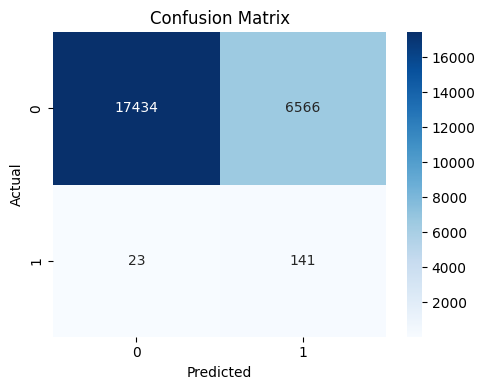

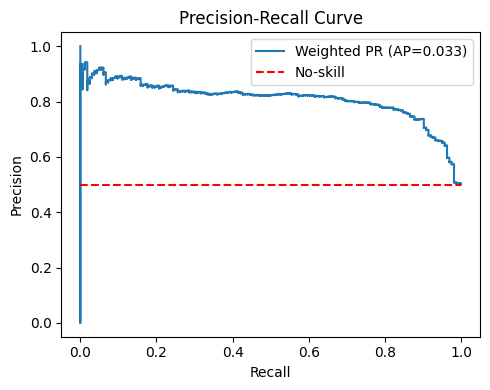

In [339]:
evaluate_model(model_5,X_val_proc, y_val)

Including category columns decreases false positives when our models are tested on validation set.

## Random Forest Classifier

In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score, average_precision_score
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

def run_rf_gridsearch(X, y, cv, class_weight_options, verbose=2, n_jobs=20):

    rf_defaults = dict(random_state=42, n_jobs=n_jobs)

    base_model = RandomForestClassifier(**rf_defaults)

    param_grid = {
        'n_estimators': [300, 400],
        'class_weight': class_weight_options,
        'max_depth': [5, 7, 10],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [3, 5],
        'max_features': ['sqrt', 'log2']
    }

    scorers = {
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_macro': make_scorer(f1_score, average='macro'),
        'pr_auc': make_scorer(average_precision_score, needs_proba=True)
    }

    gcv = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring=scorers,
        refit='recall_macro',
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose,
        error_score='raise'
    )

    gcv.fit(X, y)

    results = pd.DataFrame(gcv.cv_results_).sort_values("mean_test_recall_macro", ascending=False)

    top_cols = [
        'param_n_estimators', 'param_class_weight', 'param_max_depth',
        'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features',
        'mean_test_recall_macro', 'mean_test_f1_macro', 'mean_test_pr_auc'
    ]

    print(results[top_cols].head(10))
    return gcv, results[top_cols]


In [106]:
# Class Weight, Balanced 
rf_class_weights = ['balanced']
gcv_rf_balanced, results_rf_balanced = run_rf_gridsearch(X_train_proc, y_train, cv=kfold, class_weight_options=rf_class_weights, verbose=2, n_jobs=n_jobs)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
    param_n_estimators param_class_weight  param_max_depth  \
11                 400           balanced                5   
15                 400           balanced                5   
13                 400           balanced                5   
10                 300           balanced                5   
14                 300           balanced                5   
12                 300           balanced                5   
8                  300           balanced                5   
9                  400           balanced                5   
0                  300           balanced                5   
7                  400           balanced                5   

    param_min_samples_split  param_min_samples_leaf param_max_features  \
11                       10                       3               log2   
15                       10                       5               log2   
13                        5      

In [115]:
val_results = evaluate_param_list(results_rf_balanced, gcv_rf_balanced.estimator, X_train_proc, y_train,
    X_val_proc, y_val, top_n=10, n_jobs=n_jobs)

display(val_results.head(10))

,n_estimators,class_weight,max_depth,min_samples_split,min_samples_leaf,max_features,recall_macro_val,f1_macro_val,pr_auc_val,confusion_matrix
3,300,balanced,5,10,3,log2,0.763171,0.492635,0.055230,"[[20681, 3319], [55, 109]]"
4,300,balanced,5,10,5,log2,0.763067,0.492533,0.055485,"[[20676, 3324], [55, 109]]"
5,300,balanced,5,5,5,log2,0.763067,0.492533,0.055485,"[[20676, 3324], [55, 109]]"
6,300,balanced,5,5,3,log2,0.762963,0.492431,0.055239,"[[20671, 3329], [55, 109]]"
0,400,balanced,5,10,3,log2,0.762734,0.492206,0.055624,"[[20660, 3340], [55, 109]]"
1,400,balanced,5,10,5,log2,0.762671,0.492145,0.055737,"[[20657, 3343], [55, 109]]"
2,400,balanced,5,5,5,log2,0.762671,0.492145,0.055737,"[[20657, 3343], [55, 109]]"
7,400,balanced,5,5,3,log2,0.762484,0.491962,0.055376,"[[20648, 3352], [55, 109]]"
9,400,balanced,5,10,5,sqrt,0.746879,0.492892,0.054717,"[[20777, 3223], [61, 103]]"
8,300,balanced,5,5,3,sqrt,0.746170,0.492200,0.053135,"[[20743, 3257], [61, 103]]"


In [116]:
# Class Weight, 250 
rf_class_weights = [{0: 1.0, 1: 250.0}]
gcv_rf_250, results_rf_250 = run_rf_gridsearch(X_train_proc, y_train, cv=kfold, class_weight_options=rf_class_weights, verbose=2, n_jobs=n_jobs)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
    param_n_estimators  param_class_weight  param_max_depth  \
8                  300  {0: 1.0, 1: 250.0}                5   
10                 300  {0: 1.0, 1: 250.0}                5   
12                 300  {0: 1.0, 1: 250.0}                5   
14                 300  {0: 1.0, 1: 250.0}                5   
11                 400  {0: 1.0, 1: 250.0}                5   
15                 400  {0: 1.0, 1: 250.0}                5   
13                 400  {0: 1.0, 1: 250.0}                5   
9                  400  {0: 1.0, 1: 250.0}                5   
3                  400  {0: 1.0, 1: 250.0}                5   
5                  400  {0: 1.0, 1: 250.0}                5   

    param_min_samples_split  param_min_samples_leaf param_max_features  \
8                         5                       3               log2   
10                       10                       3               log2   
12                    

In [117]:
val_results = evaluate_param_list(results_rf_250, gcv_rf_250.estimator, X_train_proc, y_train,
    X_val_proc, y_val, top_n=10, n_jobs=n_jobs)

display(val_results.head(10))

,n_estimators,class_weight,max_depth,min_samples_split,min_samples_leaf,max_features,recall_macro_val,f1_macro_val,pr_auc_val,confusion_matrix
8,400,"{0: 1.0, 1: 250.0}",5,10,3,sqrt,0.771489,0.428181,0.056953,"[[16690, 7310], [25, 139]]"
9,400,"{0: 1.0, 1: 250.0}",5,5,5,sqrt,0.771489,0.428181,0.056931,"[[16690, 7310], [25, 139]]"
5,400,"{0: 1.0, 1: 250.0}",5,10,5,log2,0.765357,0.418502,0.057374,"[[16103, 7897], [23, 141]]"
6,400,"{0: 1.0, 1: 250.0}",5,5,5,log2,0.765357,0.418502,0.057374,"[[16103, 7897], [23, 141]]"
7,400,"{0: 1.0, 1: 250.0}",5,5,3,log2,0.765316,0.418468,0.057331,"[[16101, 7899], [23, 141]]"
4,400,"{0: 1.0, 1: 250.0}",5,10,3,log2,0.765295,0.418451,0.057333,"[[16100, 7900], [23, 141]]"
0,300,"{0: 1.0, 1: 250.0}",5,5,3,log2,0.760489,0.419244,0.058604,"[[16162, 7838], [25, 139]]"
2,300,"{0: 1.0, 1: 250.0}",5,5,5,log2,0.760447,0.419210,0.058843,"[[16160, 7840], [25, 139]]"
3,300,"{0: 1.0, 1: 250.0}",5,10,5,log2,0.760447,0.419210,0.058843,"[[16160, 7840], [25, 139]]"
1,300,"{0: 1.0, 1: 250.0}",5,10,3,log2,0.760405,0.419176,0.058795,"[[16158, 7842], [25, 139]]"


In [118]:
# Class Weight, 400 
rf_class_weights = [{0: 1.0, 1: 400.0}]
gcv_rf_400, results_rf_400 = run_rf_gridsearch(X_train_proc, y_train, cv=kfold, class_weight_options=rf_class_weights, verbose=2, n_jobs=n_jobs)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
    param_n_estimators  param_class_weight  param_max_depth  \
1                  400  {0: 1.0, 1: 400.0}                5   
0                  300  {0: 1.0, 1: 400.0}                5   
5                  400  {0: 1.0, 1: 400.0}                5   
7                  400  {0: 1.0, 1: 400.0}                5   
3                  400  {0: 1.0, 1: 400.0}                5   
15                 400  {0: 1.0, 1: 400.0}                5   
13                 400  {0: 1.0, 1: 400.0}                5   
2                  300  {0: 1.0, 1: 400.0}                5   
4                  300  {0: 1.0, 1: 400.0}                5   
6                  300  {0: 1.0, 1: 400.0}                5   

    param_min_samples_split  param_min_samples_leaf param_max_features  \
1                         5                       3               sqrt   
0                         5                       3               sqrt   
5                     

In [119]:
val_results = evaluate_param_list(results_rf_400, gcv_rf_400.estimator, X_train_proc, y_train,
    X_val_proc, y_val, top_n=10, n_jobs=n_jobs)

display(val_results.head(10))

,n_estimators,class_weight,max_depth,min_samples_split,min_samples_leaf,max_features,recall_macro_val,f1_macro_val,pr_auc_val,confusion_matrix
2,400,"{0: 1.0, 1: 400.0}",5,5,5,sqrt,0.725603,0.348676,0.056210,"[[12146, 11854], [9, 155]]"
3,400,"{0: 1.0, 1: 400.0}",5,10,5,sqrt,0.725603,0.348676,0.056210,"[[12146, 11854], [9, 155]]"
4,400,"{0: 1.0, 1: 400.0}",5,10,3,sqrt,0.725478,0.348559,0.056187,"[[12140, 11860], [9, 155]]"
0,400,"{0: 1.0, 1: 400.0}",5,5,3,sqrt,0.725123,0.348229,0.056413,"[[12123, 11877], [9, 155]]"
8,300,"{0: 1.0, 1: 400.0}",5,5,5,sqrt,0.724804,0.350676,0.056454,"[[12254, 11746], [10, 154]]"
9,300,"{0: 1.0, 1: 400.0}",5,10,5,sqrt,0.724804,0.350676,0.056454,"[[12254, 11746], [10, 154]]"
7,300,"{0: 1.0, 1: 400.0}",5,10,3,sqrt,0.724637,0.350522,0.056429,"[[12246, 11754], [10, 154]]"
1,300,"{0: 1.0, 1: 400.0}",5,5,3,sqrt,0.723825,0.349767,0.056369,"[[12207, 11793], [10, 154]]"
5,400,"{0: 1.0, 1: 400.0}",5,10,5,log2,0.705131,0.326273,0.062342,"[[11017, 12983], [8, 156]]"
6,400,"{0: 1.0, 1: 400.0}",5,5,5,log2,0.705131,0.326273,0.062342,"[[11017, 12983], [8, 156]]"


#### Best Models With Random Forest Classifier

In [353]:
model_7 = RandomForestClassifier(
    n_estimators=300,
    class_weight={0: 1.0, 1: 250.0},
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=3,
    max_features='log2', 
    random_state=42,
    n_jobs=n_jobs
)
model_7.fit(X_train_proc, y_train)
joblib.dump(model_7, "../Models/model_7.pkl")

['../Models/model_7.pkl']

 Validation Results:
Recall (macro):     0.7604
F1-score (macro):   0.4192
PR-AUC:             0.0588
              precision    recall  f1-score   support

           0       1.00      0.67      0.80     24000
           1       0.02      0.85      0.03       164

    accuracy                           0.67     24164
   macro avg       0.51      0.76      0.42     24164
weighted avg       0.99      0.67      0.80     24164



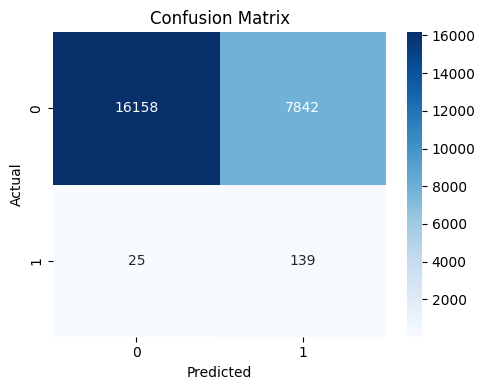

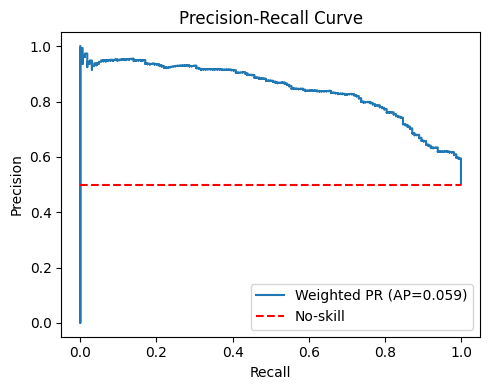

In [357]:
evaluate_model(model_7,X_val_proc, y_val)

#### Random Forest Without Category

In [253]:
# Class Weight, 250, 300
rf_class_weights = [{0: 1.0, 1: 250.0},{0: 1.0, 1: 300.0}]
gcv_rf_250_wo_cat, results_rf_250_wo_cat = run_rf_gridsearch(X_train_proc_wo_cat, y_train, cv=kfold, class_weight_options=rf_class_weights, verbose=2, n_jobs=n_jobs)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
    param_n_estimators  param_class_weight  param_max_depth  \
56                 300  {0: 1.0, 1: 300.0}                5   
61                 400  {0: 1.0, 1: 300.0}                5   
63                 400  {0: 1.0, 1: 300.0}                5   
58                 300  {0: 1.0, 1: 300.0}                5   
60                 300  {0: 1.0, 1: 300.0}                5   
62                 300  {0: 1.0, 1: 300.0}                5   
57                 400  {0: 1.0, 1: 300.0}                5   
59                 400  {0: 1.0, 1: 300.0}                5   
9                  400  {0: 1.0, 1: 250.0}                5   
11                 400  {0: 1.0, 1: 250.0}                5   

    param_min_samples_split  param_min_samples_leaf param_max_features  \
56                        5                       3               log2   
61                        5                       5               log2   
63                    

In [254]:
val_results = evaluate_param_list(results_rf_250_wo_cat, gcv_rf_250_wo_cat.estimator, X_train_proc_wo_cat, y_train,
    X_val_proc_wo_cat, y_val, top_n=10, n_jobs=n_jobs)

display(val_results.head(10))

,n_estimators,class_weight,max_depth,min_samples_split,min_samples_leaf,max_features,recall_macro_val,f1_macro_val,pr_auc_val,confusion_matrix
8,400,"{0: 1.0, 1: 250.0}",5,5,3,log2,0.764676,0.422651,0.052946,"[[16363, 7637], [25, 139]]"
9,400,"{0: 1.0, 1: 250.0}",5,10,3,log2,0.764385,0.422414,0.053414,"[[16349, 7651], [25, 139]]"
6,400,"{0: 1.0, 1: 300.0}",5,5,3,log2,0.734274,0.392735,0.051731,"[[14611, 9389], [23, 141]]"
1,400,"{0: 1.0, 1: 300.0}",5,5,5,log2,0.733732,0.392278,0.051763,"[[14585, 9415], [23, 141]]"
2,400,"{0: 1.0, 1: 300.0}",5,10,5,log2,0.733732,0.392278,0.051763,"[[14585, 9415], [23, 141]]"
7,400,"{0: 1.0, 1: 300.0}",5,10,3,log2,0.733711,0.392260,0.051763,"[[14584, 9416], [23, 141]]"
0,300,"{0: 1.0, 1: 300.0}",5,5,3,log2,0.733191,0.391820,0.052548,"[[14559, 9441], [23, 141]]"
3,300,"{0: 1.0, 1: 300.0}",5,10,3,log2,0.733149,0.391784,0.052555,"[[14557, 9443], [23, 141]]"
4,300,"{0: 1.0, 1: 300.0}",5,5,5,log2,0.733149,0.391784,0.052555,"[[14557, 9443], [23, 141]]"
5,300,"{0: 1.0, 1: 300.0}",5,10,5,log2,0.733149,0.391784,0.052555,"[[14557, 9443], [23, 141]]"


#### Best Random Forest Models Without Category

When we tested best models obtained above and also model_7, we observed that model_7 shows similar performance when categoris are excluded. So we will choose model_7 as our best model here.

In [355]:
model_7_wo_cat = RandomForestClassifier(
    n_estimators=300,
    class_weight={0: 1.0, 1: 250.0},
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=3,
    max_features='log2', 
    random_state=42,
    n_jobs=n_jobs
)
model_7_wo_cat.fit(X_train_proc_wo_cat, y_train)
joblib.dump(model_7_wo_cat, "../Models/model_7_wo_cat.pkl")

['../Models/model_7_wo_cat.pkl']

## XGBoost

In [127]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score, average_precision_score
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

def run_xgb_gridsearch(X, y, cv, scale_pos_weight_options, verbose=2, n_jobs=20):

    base_model = XGBClassifier(
        n_estimators=300,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        n_jobs=n_jobs
    )

    param_grid = {
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.5, 1.0],
        'reg_lambda': [0.5, 1.0, 2.0],
        'scale_pos_weight': scale_pos_weight_options
    }

    scorers = {
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_macro': make_scorer(f1_score, average='macro'),
        'pr_auc': make_scorer(average_precision_score, needs_proba=True)
    }

    gcv = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring=scorers,
        refit='recall_macro',
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose,
        error_score='raise'
    )

    gcv.fit(X, y)

    results = pd.DataFrame(gcv.cv_results_).sort_values("mean_test_recall_macro", ascending=False)

    top_cols = [
        'param_max_depth', 'param_learning_rate', 'param_subsample',
        'param_colsample_bytree', 'param_reg_alpha', 'param_reg_lambda',
        'param_scale_pos_weight',
        'mean_test_recall_macro', 'mean_test_f1_macro', 'mean_test_pr_auc'
    ]

    print(results[top_cols].head(10))
    return gcv, results[top_cols]


In [129]:
# balanced 
scale_weights = [sum(y_train==0)/sum(y_train==1)]
gcv_xgb_balanced, results_xgb_balanced = run_xgb_gridsearch(X_train_proc, y_train, cv=kfold, scale_pos_weight_options=scale_weights, verbose=2, n_jobs=n_jobs)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
     param_max_depth  param_learning_rate  param_subsample  \
432                3                 0.05              0.6   
759                3                 0.05              0.6   
780                3                 0.05              0.6   
762                3                 0.05              0.6   
450                3                 0.05              0.6   
756                3                 0.05              0.6   
771                3                 0.05              0.6   
444                3                 0.05              0.6   
765                3                 0.05              0.6   
123                3                 0.05              0.6   

     param_colsample_bytree  param_reg_alpha  param_reg_lambda  \
432                     0.8              0.0               0.5   
759                     1.0              0.0               1.0   
780                     1.0              1.0           

In [130]:
val_results = evaluate_param_list(results_xgb_balanced, gcv_xgb_balanced.estimator, X_train_proc, y_train,
    X_val_proc, y_val, top_n=10, n_jobs=n_jobs)

display(val_results.head(10))

,max_depth,learning_rate,subsample,colsample_bytree,reg_alpha,reg_lambda,scale_pos_weight,recall_macro_val,f1_macro_val,pr_auc_val,confusion_matrix
3,3,0.05,0.6,1.0,0.0,2.0,145.833333,0.749420,0.504156,0.041928,"[[21338, 2662], [64, 100]]"
0,3,0.05,0.6,0.8,0.0,0.5,145.833333,0.747482,0.502015,0.042597,"[[21245, 2755], [64, 100]]"
1,3,0.05,0.6,1.0,0.0,1.0,145.833333,0.745871,0.503259,0.042664,"[[21314, 2686], [65, 99]]"
8,3,0.05,0.6,1.0,0.5,0.5,145.833333,0.745600,0.502960,0.042581,"[[21301, 2699], [65, 99]]"
2,3,0.05,0.6,1.0,1.0,2.0,145.833333,0.742614,0.502692,0.042582,"[[21304, 2696], [66, 98]]"
6,3,0.05,0.6,1.0,0.5,2.0,145.833333,0.739982,0.502812,0.041757,"[[21324, 2676], [67, 97]]"
5,3,0.05,0.6,1.0,0.0,0.5,145.833333,0.739732,0.502537,0.041620,"[[21312, 2688], [67, 97]]"
4,3,0.05,0.6,0.8,1.0,0.5,145.833333,0.739315,0.502082,0.041771,"[[21292, 2708], [67, 97]]"
7,3,0.05,0.6,0.8,0.5,1.0,145.833333,0.738940,0.501674,0.041644,"[[21274, 2726], [67, 97]]"
9,3,0.05,0.6,0.6,0.5,2.0,145.833333,0.738107,0.500776,0.045041,"[[21234, 2766], [67, 97]]"


In [136]:
# 250
scale_weights = [250.0]
gcv_xgb_250, results_xgb_250 = run_xgb_gridsearch(X_train_proc, y_train, cv=kfold, scale_pos_weight_options=scale_weights, verbose=2, n_jobs=n_jobs)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
     param_max_depth  param_learning_rate  param_subsample  \
132                3                 0.05              0.6   
108                3                 0.05              0.6   
114                3                 0.05              0.6   
117                3                 0.05              0.6   
48                 4                 0.01              0.6   
42                 4                 0.01              0.6   
33                 4                 0.01              0.6   
30                 4                 0.01              0.6   
123                3                 0.05              0.6   
756                3                 0.05              0.6   

     param_colsample_bytree  param_reg_alpha  param_reg_lambda  \
132                     0.6              1.0               2.0   
108                     0.6              0.0               0.5   
114                     0.6              0.0           

In [137]:
val_results = evaluate_param_list(results_xgb_250, gcv_xgb_250.estimator, X_train_proc, y_train,
    X_val_proc, y_val, top_n=10, n_jobs=n_jobs)

display(val_results.head(10))

,max_depth,learning_rate,subsample,colsample_bytree,reg_alpha,reg_lambda,scale_pos_weight,recall_macro_val,f1_macro_val,pr_auc_val,confusion_matrix
7,4,0.01,0.6,0.6,0.0,1.0,250.0,0.786315,0.449487,0.044963,"[[17987, 6013], [29, 135]]"
5,4,0.01,0.6,0.6,0.5,2.0,250.0,0.783474,0.449491,0.045161,"[[17997, 6003], [30, 134]]"
4,4,0.01,0.6,0.6,1.0,1.0,250.0,0.782974,0.449084,0.045545,"[[17973, 6027], [30, 134]]"
6,4,0.01,0.6,0.6,0.0,2.0,250.0,0.782828,0.448965,0.044643,"[[17966, 6034], [30, 134]]"
1,3,0.05,0.6,0.6,0.0,0.5,250.0,0.781187,0.480896,0.043428,"[[19936, 4064], [44, 120]]"
3,3,0.05,0.6,0.6,0.5,0.5,250.0,0.777722,0.480288,0.042975,"[[19916, 4084], [45, 119]]"
9,3,0.05,0.6,1.0,0.0,0.5,250.0,0.771242,0.481979,0.040837,"[[20044, 3956], [48, 116]]"
0,3,0.05,0.6,0.6,1.0,2.0,250.0,0.770117,0.480966,0.044307,"[[19990, 4010], [48, 116]]"
2,3,0.05,0.6,0.6,0.0,2.0,250.0,0.764061,0.480529,0.041502,"[[19992, 4008], [50, 114]]"
8,3,0.05,0.6,0.6,0.5,2.0,250.0,0.763311,0.479860,0.042257,"[[19956, 4044], [50, 114]]"


In [138]:
# 400
scale_weights = [400.0]
gcv_xgb_400, results_xgb_400 = run_xgb_gridsearch(X_train_proc, y_train, cv=kfold, scale_pos_weight_options=scale_weights, verbose=2, n_jobs=n_jobs)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
     param_max_depth  param_learning_rate  param_subsample  \
108                3                 0.05              0.6   
126                3                 0.05              0.6   
120                3                 0.05              0.6   
438                3                 0.05              0.6   
72                 5                 0.01              0.6   
117                3                 0.05              0.6   
24                 3                 0.01              0.6   
6                  3                 0.01              0.6   
57                 5                 0.01              0.6   
66                 5                 0.01              0.6   

     param_colsample_bytree  param_reg_alpha  param_reg_lambda  \
108                     0.6              0.0               0.5   
126                     0.6              1.0               0.5   
120                     0.6              0.5           

In [139]:
val_results = evaluate_param_list(results_xgb_400, gcv_xgb_400.estimator, X_train_proc, y_train,
    X_val_proc, y_val, top_n=10, n_jobs=n_jobs)

display(val_results.head(10))

,max_depth,learning_rate,subsample,colsample_bytree,reg_alpha,reg_lambda,scale_pos_weight,recall_macro_val,f1_macro_val,pr_auc_val,confusion_matrix
3,3,0.05,0.6,0.8,0.0,2.0,400.0,0.790078,0.461935,0.037305,"[[18753, 5247], [33, 131]]"
8,5,0.01,0.6,0.6,0.0,1.0,400.0,0.786058,0.437667,0.046597,"[[17243, 6757], [24, 140]]"
9,5,0.01,0.6,0.6,0.5,1.0,400.0,0.783301,0.437755,0.046581,"[[17257, 6743], [25, 139]]"
4,5,0.01,0.6,0.6,1.0,0.5,400.0,0.783260,0.437721,0.045746,"[[17255, 6745], [25, 139]]"
2,3,0.05,0.6,0.6,0.5,1.0,400.0,0.781939,0.459868,0.039467,"[[18655, 5345], [35, 129]]"
0,3,0.05,0.6,0.6,0.0,0.5,400.0,0.781897,0.459834,0.043895,"[[18653, 5347], [35, 129]]"
5,3,0.05,0.6,0.6,0.5,0.5,400.0,0.774716,0.458574,0.041440,"[[18601, 5399], [37, 127]]"
1,3,0.05,0.6,0.6,1.0,0.5,400.0,0.768660,0.458244,0.043042,"[[18603, 5397], [39, 125]]"
7,3,0.01,0.6,0.6,0.0,2.0,400.0,0.734859,0.362571,0.046985,"[[12883, 11117], [11, 153]]"
6,3,0.01,0.6,0.6,1.0,2.0,400.0,0.733755,0.361573,0.047855,"[[12830, 11170], [11, 153]]"


#### Best Model With Category

In [359]:
model_8 = XGBClassifier(
    n_estimators=300, max_depth=5, learning_rate=0.01,
    subsample=0.6, colsample_bytree=0.6,
    reg_alpha=0.5, reg_lambda=1.0,
    scale_pos_weight=400.0,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42, n_jobs=n_jobs)

model_8.fit(X_train_proc, y_train)
joblib.dump(model_8, "../Models/model_8.pkl")

['../Models/model_8.pkl']

### Xgboost Without Category

In [281]:
scale_weights = [400.0]
gcv_xgb_400_wo_cat, results_xgb_400_wo_cat = run_xgb_gridsearch(X_train_proc_wo_cat, y_train, cv=kfold, scale_pos_weight_options=scale_weights, verbose=2, n_jobs=n_jobs)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
     param_max_depth  param_learning_rate  param_subsample  \
435                3                 0.05              0.6   
432                3                 0.05              0.6   
124                3                 0.05              0.8   
442                3                 0.05              0.8   
115                3                 0.05              0.8   
781                3                 0.05              0.8   
458                3                 0.05              1.0   
439                3                 0.05              0.8   
113                3                 0.05              1.0   
438                3                 0.05              0.6   

     param_colsample_bytree  param_reg_alpha  param_reg_lambda  \
435                     0.8              0.0               1.0   
432                     0.8              0.0               0.5   
124                     0.6              0.5           

In [282]:
val_results = evaluate_param_list(results_xgb_400_wo_cat, gcv_xgb_400_wo_cat.estimator, X_train_proc_wo_cat, y_train,
    X_val_proc_wo_cat, y_val, top_n=10, n_jobs=n_jobs)

display(val_results.head(10))

,max_depth,learning_rate,subsample,colsample_bytree,reg_alpha,reg_lambda,scale_pos_weight,recall_macro_val,f1_macro_val,pr_auc_val,confusion_matrix
6,3,0.05,1.0,0.8,1.0,2.0,400.0,0.779293,0.450720,0.046527,"[[18089, 5911], [32, 132]]"
8,3,0.05,1.0,0.6,0.0,1.0,400.0,0.777877,0.449567,0.043284,"[[18021, 5979], [32, 132]]"
5,3,0.05,0.8,1.0,1.0,2.0,400.0,0.772758,0.456966,0.039967,"[[18507, 5493], [37, 127]]"
2,3,0.05,0.8,0.6,0.5,2.0,400.0,0.771098,0.453296,0.043343,"[[18281, 5719], [36, 128]]"
9,3,0.05,0.6,0.8,0.0,2.0,400.0,0.768077,0.457766,0.040789,"[[18575, 5425], [39, 125]]"
4,3,0.05,0.8,0.6,0.0,2.0,400.0,0.768008,0.453089,0.043904,"[[18279, 5721], [37, 127]]"
3,3,0.05,0.8,0.8,0.5,0.5,400.0,0.762861,0.455816,0.041099,"[[18471, 5529], [40, 124]]"
1,3,0.05,0.6,0.8,0.0,0.5,400.0,0.762229,0.457607,0.039815,"[[18587, 5413], [41, 123]]"
7,3,0.05,0.8,0.8,0.0,2.0,400.0,0.761778,0.454935,0.041993,"[[18419, 5581], [40, 124]]"
0,3,0.05,0.6,0.8,0.0,1.0,400.0,0.759014,0.457289,0.040095,"[[18579, 5421], [42, 122]]"


In [361]:
model_8_wo_cat = XGBClassifier(
    n_estimators=300, max_depth=5, learning_rate=0.01,
    subsample=0.6, colsample_bytree=0.6,
    reg_alpha=0.5, reg_lambda=1.0,
    scale_pos_weight=400.0,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42, n_jobs=n_jobs)

model_8_wo_cat.fit(X_train_proc_wo_cat,y_train)
joblib.dump(model_8_wo_cat, "../Models/model_8_wo_cat.pkl")

['../Models/model_8_wo_cat.pkl']

## Voting Classifier

validation
 Validation Results:
Recall (macro):     0.7895
F1-score (macro):   0.4312
PR-AUC:             0.0479
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     24000
           1       0.02      0.88      0.04       164

    accuracy                           0.70     24164
   macro avg       0.51      0.79      0.43     24164
weighted avg       0.99      0.70      0.82     24164



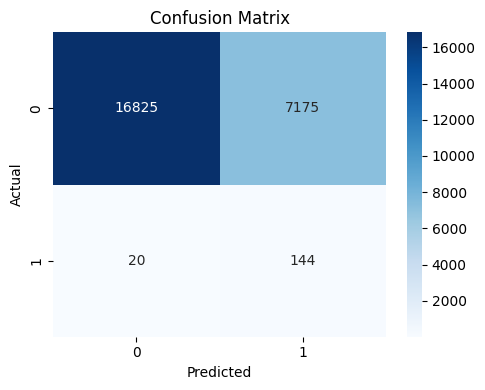

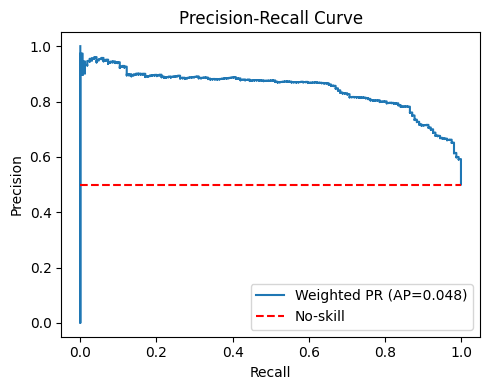

In [363]:
from sklearn.ensemble import VotingClassifier
from evaluator import evaluate_model
# Train separate models with different class weights
model_4 = LogisticRegression(penalty='l2', solver='newton-cg', C=1.0, class_weight='balanced', max_iter=1000, random_state=42)
model_5 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, class_weight={0: 1, 1: 250}, max_iter=1000, random_state=42) # best overall
model_6 = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, class_weight={0: 1, 1: 400}, max_iter=1000, random_state=42)

model_7 = RandomForestClassifier(
    n_estimators=300,
    class_weight={0: 1.0, 1: 250.0},
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=3,
    max_features='log2', 
    random_state=42,
    n_jobs=n_jobs
)


model_8 = XGBClassifier(
    n_estimators=300, max_depth=5, learning_rate=0.01,
    subsample=0.6, colsample_bytree=0.6,
    reg_alpha=0.5, reg_lambda=1.0,
    scale_pos_weight=400.0,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42, n_jobs=n_jobs)

voting1 = VotingClassifier(
    estimators=[('model_5', model_5), ('model_6', model_6),('model_7',model_7),('model_8',model_8)],
    voting='soft', 
    n_jobs=n_jobs
)

voting1.fit(X_train_proc, y_train)
print("validation")
evaluate_model(voting1, X_val_proc, y_val)

validation
 Validation Results:
Recall (macro):     0.8014
F1-score (macro):   0.4409
PR-AUC:             0.0503
              precision    recall  f1-score   support

           0       1.00      0.72      0.84     24000
           1       0.02      0.88      0.04       164

    accuracy                           0.73     24164
   macro avg       0.51      0.80      0.44     24164
weighted avg       0.99      0.73      0.83     24164



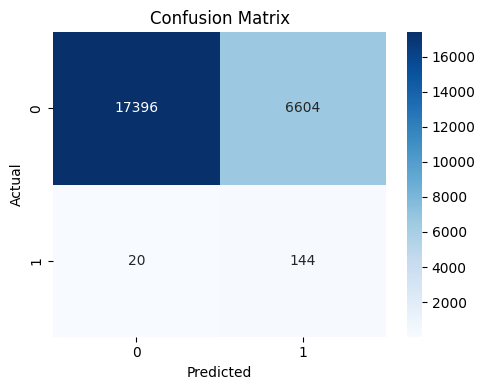

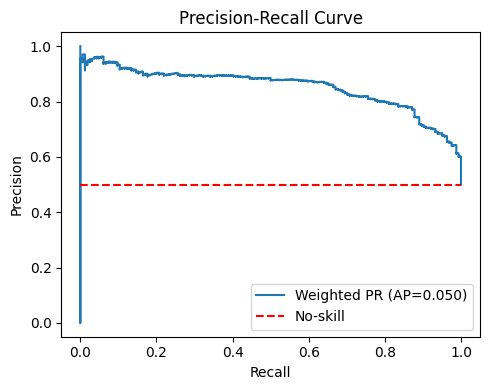

In [365]:
voting2 = VotingClassifier(
    estimators=[('model_5', model_5),('model_7',model_7),('model_8',model_8)],
    voting='soft', 
    n_jobs=n_jobs
)

voting2.fit(X_train_proc, y_train)
print("validation")
evaluate_model(voting2, X_val_proc, y_val)

validation
 Validation Results:
Recall (macro):     0.7948
F1-score (macro):   0.4424
PR-AUC:             0.0544
              precision    recall  f1-score   support

           0       1.00      0.73      0.84     24000
           1       0.02      0.86      0.04       164

    accuracy                           0.73     24164
   macro avg       0.51      0.79      0.44     24164
weighted avg       0.99      0.73      0.84     24164



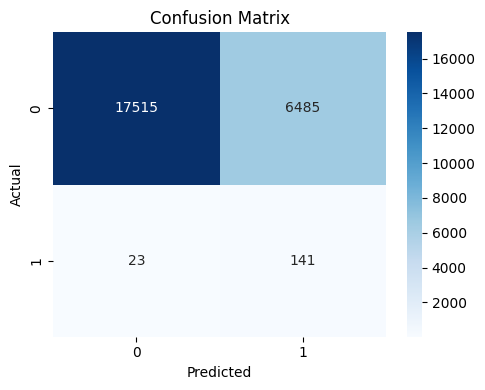

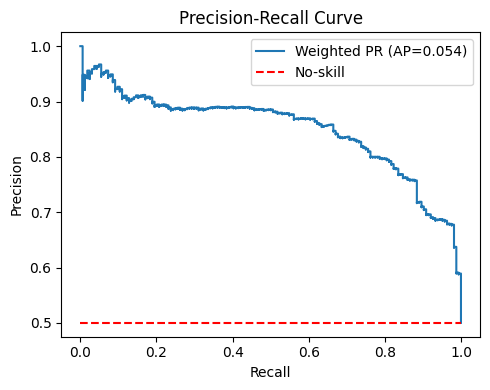

In [367]:
from sklearn.ensemble import VotingClassifier

# Train separate models with different class weights
lr_600 = LogisticRegression(C=0.01, penalty='l1', solver='liblinear',
                            class_weight={0: 1, 1: 600}, max_iter=1000, random_state=42)
lr_bal = LogisticRegression(C=0.01, penalty='l1', solver='liblinear',
                            class_weight='balanced', max_iter=1000, random_state=42)
rf = RandomForestClassifier(
    class_weight={0: 1.0, 1: 600.0}, max_depth=7,
    max_features='log2', min_samples_leaf=3,
    min_samples_split=5, n_estimators=400,
    random_state=42, n_jobs=-1)

rf2 = RandomForestClassifier(
    class_weight={0: 1.0, 1: 145.0}, max_depth=7,
    max_features='log2', min_samples_leaf=3,
    min_samples_split=5, n_estimators=400,
    random_state=42, n_jobs=-1)

xgb_base = XGBClassifier(
    n_estimators=300, max_depth=3, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.6,
    reg_alpha=1.0, reg_lambda=2.0,
    scale_pos_weight=600.0,
    use_label_encoder=False, eval_metric='logloss',
    random_state=42, n_jobs=-1)

voting3 = VotingClassifier(
    estimators=[('lr600', lr_600), ('lr_bal', lr_bal),('rf',rf),('rf2',rf2),('xgb_base',xgb_base)],
    voting='soft', 
    n_jobs=-1
)

voting3.fit(X_train_proc, y_train)
print("validation")
evaluate_model(voting3, X_val_proc, y_val)

We will save `voting2`, as it achieves higher recall compared to `voting3`, despite producing slightly more false positives.

In [380]:
joblib.dump(voting2, "../Models/voting2.pkl")

['../Models/voting2.pkl']